# **Topic MOdelling**

This is a simple notebook that explains topic modelling using tweets. the Idea is to classify which tweets are about real disasters and which are not.
___________________________________________________________________________________________________________________________________
The datasets consis of five columns:
___________________________________________________________________________________________________________________________________


id: a unique identifier for each tweet

text: the text of the tweet

location: the location the tweet was sent from (may be blank)

keyword: a particular keyword from the tweet (may be blank)

target: in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

**Step 1: Make necessary importations**

In [2]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from tensorflow import keras
from keras import (layers, models)

ModuleNotFoundError: No module named 'tensorflow'

**Step 2: Exploratory Data Analysis** 

In [6]:
Train = pd.read_csv("/home/godsent/Downloads/test.csv")
Test = pd.read_csv("/home/godsent/Downloads/test.csv")

In [4]:
Train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
Test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
print(Train.shape)
print(Test.shape)

(7613, 5)
(3263, 4)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


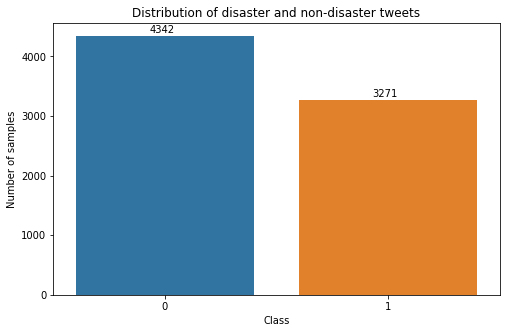

In [8]:
# Visualization of the Train Dataset

plt.figure(figsize = (8,5))
ax = sns.countplot(Train["target"])

plt.title("Distribution of disaster and non-disaster tweets")
plt.xlabel("Class")
plt.ylabel("Number of samples")

for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.33, p.get_height()+50))

plt.show()

This data contains 3271 disaster tweets & 4342 non-disaster tweets

In [9]:
Train["keyword"].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [10]:
Train["location"].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [11]:
Train["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [12]:
# View the tweets classified as actual/real disasters 

DisasterTweets = Train["text"][Train.target == 1]

DisasterTweets

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

**Step 3: Data Cleaning & Preparation**

In [15]:
Train ["text"] = Train ["text"] + ' ' + Train ["keyword"].astype(str)
Test ["text"] = Test ["text"] + ' ' + Test ["keyword"].astype(str)

In [16]:
def CleanText(text):
    
    text = text.lower() # convert text to lowercase
    text = re.sub(r'[^\w\s]',"",text) # remove punctuation
    text = re.sub(" \d+", " ", text) # remove pure number strings
    text = re.sub(r'http\S+',"", text) # remove hyperlinks
    
    sw = stopwords.words("english")  
    text = " ".join([word for word in text.split() if word not in sw]) # remove stopwords
    
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()]) # lemmatize words               
    
    return text

In [17]:
# example to try out the function

ExampleText = "The quick brown fox jumped over the lazy Dog"
CleanText(ExampleText)

'quick brown fox jumped lazy dog'

In [18]:
Train ["text"] = Train ["text"].apply(lambda x: CleanText(x)).str.replace("nan", "")
Test ["text"] = Test ["text"].apply(lambda x: CleanText(x)).str.replace("nan", "")

**Step 4: Word Index**

In [19]:
TrainWords = Train.text.str.split (expand = True).stack().value_counts() [:9997] # select 9997 most frequent words for building vocabulary

WordIndex = dict()    # dictionary of word index

for i in range (len(TrainWords)):
    WordIndex [TrainWords.index[i]] = i + 3
    
WordIndex["PAD"] = 0 # for padding
WordIndex["START"] = 1 # denotes start of sequence
WordIndex["UNK"] = 2 # for words out of vocabulary

ReverseWordIndex = {v:k for (k,v) in WordIndex.items()} # reverse word index mapping number to word

**Step 5: Text Tokenization**

In [21]:
def TokenizeText (text):
    
    sen = ["START"]
    
    for word in text.split():
        if word in WordIndex.keys():
            sen.append(word)
        else:
            sen.append("UNK")
    
    tokens = []  
    
    for word in sen:
        tokens.append(int(WordIndex[word]))
    return tokens       

In [22]:
TrainTokenized = Train["text"].apply(lambda x: TokenizeText(x))
TestTokenized = Test["text"].apply(lambda x: TokenizeText(x))

In [23]:
TrainTokenized

0                 [1, 4582, 537, 51, 215, 1465, 4309, 10]
1                       [1, 276, 3, 331, 576, 2, 2, 1147]
2       [1, 1704, 1494, 2042, 544, 2, 460, 59, 2042, 5...
3                    [1, 4676, 21, 5338, 38, 59, 481, 66]
4         [1, 100, 1180, 291, 2, 1878, 85, 38, 6250, 259]
                              ...                        
7608           [1, 184, 714, 1084, 940, 412, 39, 605, 45]
7609    [1, 4427, 4623, 756, 379, 3, 66, 256, 297, 434...
7610                           [1, 3055, 4281, 223, 1341]
7611    [1, 18, 1026, 2835, 62, 97, 369, 5150, 2835, 1...
7612              [1, 314, 45, 166, 297, 66, 38, 622, 23]
Name: text, Length: 7613, dtype: object

**Step 6: Create one hot encoded matrix for train data. Each sample will be a 10000 dimensional vector**

In [24]:
dim = 10000
OneHotMatrix = np.zeros((len(Train), dim))
for (i, vec) in enumerate(TrainTokenized):
    for v in vec:
        OneHotMatrix[i, v] = 1.

In [25]:
y = Train["target"].astype(float)

**Step 7: Spitting data into train and validation sets**

In [26]:
ValSplit = .15
ValStartIdx = int(OneHotMatrix.shape[0] * (1 - ValSplit))
ValData = OneHotMatrix[ValStartIdx:, :]
ValLabels = y[ValStartIdx:]
ValData = OneHotMatrix[ValStartIdx:, :]
ValLabels = y[ValStartIdx:]
TrainData = OneHotMatrix[:ValStartIdx, :]
TrainLabels = y[:ValStartIdx]

**Step 8: Model  build**

In [28]:
model = models.Sequential()
model.add (layers.Dense(32, activation = "relu", input_shape = (dim, )))
model.add (layers.Dropout(0.4))
model.add (layers.Dense(8, activation = "relu"))
model.add (layers.Dense(1, activation = "sigmoid"))

In [29]:
model.compile (optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

In [30]:
history = model.fit(TrainData, TrainLabels, epochs = 15, batch_size = 256, validation_data = (ValData, ValLabels))

Epoch 1/15
26/26 [==============================] - 2s 32ms/step - loss: 0.6798 - accuracy: 0.6326 - val_loss: 0.6318 - val_accuracy: 0.7732
Epoch 2/15
26/26 [==============================] - 0s 19ms/step - loss: 0.5890 - accuracy: 0.8098 - val_loss: 0.5593 - val_accuracy: 0.7828
Epoch 3/15
26/26 [==============================] - 0s 18ms/step - loss: 0.4966 - accuracy: 0.8371 - val_loss: 0.5066 - val_accuracy: 0.7890
Epoch 4/15
26/26 [==============================] - 0s 18ms/step - loss: 0.4251 - accuracy: 0.8519 - val_loss: 0.4746 - val_accuracy: 0.7863
Epoch 5/15
26/26 [==============================] - 0s 18ms/step - loss: 0.3659 - accuracy: 0.8755 - val_loss: 0.4609 - val_accuracy: 0.7846
Epoch 6/15
26/26 [==============================] - 0s 17ms/step - loss: 0.3253 - accuracy: 0.8849 - val_loss: 0.4574 - val_accuracy: 0.7811
Epoch 7/15
26/26 [==============================] - 0s 18ms/step - loss: 0.3001 - accuracy: 0.8935 - val_loss: 0.4563 - val_accuracy: 0.7750
Epoch 8/15
26

**Step 9: Loss and Accuracy plots**

In [ ]:
TrainLoss = history.history["loss"]
TrainAccuracy = history.history["accuracy"]
ValLoss = history.history["val_loss"]
ValAccuracy = history.history["val_accuracy"]
epochs = range(1, len(TrainLoss) + 1)

plt.clf()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,5))
fig

ax1.plot(epochs, TrainLoss, "b", label = "Training loss")
ax1.plot(epochs, ValLoss, "r", label = "Validation loss")
ax1.set_title("Training & Validation loss")
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.legend()

ax2.plot(epochs, TrainAccuracy, "b", label = "Training accuracy")
ax2.plot(epochs, ValAccuracy, "r", label = "Validation accuracy")
ax2.set_title("Training & Validation acc")
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.show()

**Step 10: Prepare test data for prediction**

In [ ]:
dim = 10000
TestData = np.zeros((len(Test), dim))

for (i, vec) in enumerate(TestTokenized):
    for v in vec:
        TestData[i, v] = 1.

In [ ]:
# Generate predictions
YTestPred = np.squeeze(np.round(model.predict(TestData),0))